<a href="https://colab.research.google.com/github/franksilva1/Amigo_secreto/blob/main/Flights_On_Time_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [1]:

import pandas as pd
import numpy as np
import zipfile
import os
import gc
import json
import subprocess
import sys
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os


from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score
import xgboost as xgb


import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    recall_score,
    precision_score
)
import warnings
warnings.filterwarnings('ignore')

#Carga de datos

In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "flight_data_2024.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "hrishitpatil/flight-data-2024",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

Using Colab cache for faster access to the 'flight-data-2024' dataset.
First 5 records:    year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0  2024      1             1            1  2024-01-01                9E   
1  2024      1             1            1  2024-01-01                9E   
2  2024      1             1            1  2024-01-01                9E   
3  2024      1             1            1  2024-01-01                9E   
4  2024      1             1            1  2024-01-01                9E   

   op_carrier_fl_num origin origin_city_name origin_state_nm  ... diverted  \
0             4814.0    JFK     New York, NY        New York  ...        0   
1             4815.0    MSP  Minneapolis, MN       Minnesota  ...        0   
2             4817.0    JFK     New York, NY        New York  ...        0   
3             4817.0    RIC     Richmond, VA        Virginia  ...        0   
4             4818.0    DTW      Detroit, MI        Michigan  ...      

In [3]:
# === 2. DEFINIR COLUMNAS Y TIPOS OPTIMIZADOS ===
columnas_a_usar = [
    'op_unique_carrier', 'origin', 'dest', 'origin_state_nm', 'dest_state_nm',
    'crs_dep_time', 'dep_delay', 'arr_delay', 'distance',
    'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
    'cancelled', 'diverted'
]

dtype_dict = {
    'op_unique_carrier': 'category',
    'origin': 'category',
    'dest': 'category',
    'origin_state_nm': 'category',
    'dest_state_nm': 'category',
    'crs_dep_time': 'float32',
    'dep_delay': 'float32',
    'arr_delay': 'float32',
    'distance': 'int32',
    'carrier_delay': 'float32',
    'weather_delay': 'float32',
    'nas_delay': 'float32',
    'security_delay': 'float32',
    'late_aircraft_delay': 'float32',
    'cancelled': 'int8',
    'diverted': 'int8'
}

# === 4. LIMPIEZA Y TRANSFORMACIÓN (bajo consumo de RAM) ===
print("\n🧹 Filtrando y transformando...")

# --- FIX START ---
# To make this cell robust to re-execution and ensure 'df' has the expected structure
# for subsequent operations, we explicitly select the desired columns and apply
# the defined dtypes from the 'df' that was loaded in cell jC4lkMc5d29l.
# This assumes the global 'df' still contains all original columns from the initial load.
# Using .copy() to ensure we're working on a new DataFrame slice and prevent SettingWithCopyWarning.

# Identify which of the desired columns are actually present in the current DataFrame
# This handles cases where the cell is re-executed on an already partially processed df.
actual_cols_to_use = [col for col in columnas_a_usar if col in df.columns]
actual_dtype_dict = {col: dtype_dict[col] for col in actual_cols_to_use}

df = df[actual_cols_to_use].astype(actual_dtype_dict).copy()
# --- FIX END ---

# Apply transformations conditionally if columns exist
if 'cancelled' in df.columns and 'diverted' in df.columns:
    df = df[(df['cancelled'] == 0) & (df['diverted'] == 0)].copy()
    df.drop(columns=['cancelled', 'diverted'], inplace=True)
elif 'cancelled' in df.columns: # If only cancelled is present, filter by it
    df = df[(df['cancelled'] == 0)].copy()
    df.drop(columns=['cancelled'], inplace=True)
elif 'diverted' in df.columns: # If only diverted is present, filter by it
    df = df[(df['diverted'] == 0)].copy()
    df.drop(columns=['diverted'], inplace=True)

df.dropna(subset=['arr_delay'], inplace=True)

# Create 'retraso' if 'arr_delay' is present and 'retraso' is not
if 'arr_delay' in df.columns and 'retraso' not in df.columns:
    df['retraso'] = (df['arr_delay'] > 0).astype('int8')

# Create 'hora_salida_programada' if 'crs_dep_time' is present and 'hora_salida_programada' is not
if 'crs_dep_time' in df.columns and 'hora_salida_programada' not in df.columns:
    df['hora_salida_programada'] = (df['crs_dep_time'] // 100).clip(0, 23).astype('int8')
    df.drop(columns=['crs_dep_time'], inplace=True)
elif 'crs_dep_time' in df.columns and 'hora_salida_programada' in df.columns:
    # If hora_salida_programada already exists but crs_dep_time is still there, drop crs_dep_time
    df.drop(columns=['crs_dep_time'], inplace=True)


for col in ['op_unique_carrier', 'origin', 'dest', 'origin_state_nm', 'dest_state_nm']:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].astype('category')

print("✅ Transformaciones completadas.")

# === 5. REPORTAR USO DE RAM ===
del columnas_a_usar, dtype_dict
gc.collect()

ram_mb = df.memory_usage(deep=True).sum() / 1024 / 1024
print(f"\n📊 Dimensiones finales: {df.shape[0]:,} × {df.shape[1]}")
print(f"💾 Uso de RAM: {ram_mb:.1f} MB ({ram_mb/1024:.2f} GB)")

if ram_mb > 2000:
    print("\n⚠️  Recomendación: Usa muestreo estratificado para modelado inicial.")

print("\n✅ Dataset listo para encoding con mínimo uso de RAM.")



🧹 Filtrando y transformando...
✅ Transformaciones completadas.

📊 Dimensiones finales: 6,965,267 × 15
💾 Uso de RAM: 325.5 MB (0.32 GB)

✅ Dataset listo para encoding con mínimo uso de RAM.


In [4]:
df.head()

,op_unique_carrier,origin,dest,origin_state_nm,dest_state_nm,dep_delay,arr_delay,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,retraso,hora_salida_programada
0,9E,JFK,DTW,New York,Michigan,-5.0,-19.0,509,0.0,0.0,0.0,0.0,0.0,0,12
1,9E,MSP,CLE,Minnesota,Ohio,-14.0,-30.0,622,0.0,0.0,0.0,0.0,0.0,0,10
2,9E,JFK,RIC,New York,Virginia,-4.0,-20.0,288,0.0,0.0,0.0,0.0,0.0,0,14
3,9E,RIC,JFK,Virginia,New York,-7.0,-42.0,288,0.0,0.0,0.0,0.0,0.0,0,16
4,9E,DTW,MKE,Michigan,Wisconsin,-5.0,-14.0,237,0.0,0.0,0.0,0.0,0.0,0,10


In [5]:
df.isnull().sum()

,0
op_unique_carrier,0
origin,0
dest,0
origin_state_nm,0
dest_state_nm,0
dep_delay,0
arr_delay,0
distance,0
carrier_delay,0
weather_delay,0


In [6]:
# ENCODING - ONE-HOT ENCODING (OPTIMIZADO PARA ALTA CARDINALIDAD)
# Solo se aplica one-hot a variables con baja cardinalidad

print("\n" + "="*60)
print("🧮 ENCODING: ONE-HOT SELECTIVO (BAJO USO DE RAM)")
print("="*60)

try:
    if 'df' not in locals() and 'df' not in globals():
        raise ValueError("DataFrame 'df' no encontrado. Ejecuta primero la carga optimizada.")
    if df is None or df.empty:
        raise ValueError("DataFrame 'df' está vacío.")

    df_para_encoding = df.copy()
    print("✅ Usando dataset preparado para encoding")
except Exception as e:
    print(f"❌ Error: {e}")
    df_encoded = None

# === IDENTIFICAR VARIABLES CATEGÓRICAS ===
categorical_cols = df_para_encoding.select_dtypes(include=['category', 'object']).columns.tolist()
print(f"\n🔍 Variables categóricas detectadas: {len(categorical_cols)}")

# Mostrar cardinalidad
cardinalidad = {}
for col in categorical_cols:
    n_unique = df_para_encoding[col].nunique()
    cardinalidad[col] = n_unique
    print(f"   • {col}: {n_unique:,} valores únicos")

# === DEFINIR LÍMITE PARA ONE-HOT ===
# Solo aplicar one-hot a variables con <= 20 categorías (ajustable)
LIMITE_CARDINALIDAD = 20

cols_onehot = [col for col, n in cardinalidad.items() if n <= LIMITE_CARDINALIDAD]
cols_no_onehot = [col for col, n in cardinalidad.items() if n > LIMITE_CARDINALIDAD]

print(f"\n🎯 Aplicando One-Hot Encoding solo a variables con ≤ {LIMITE_CARDINALIDAD} categorías:")
if cols_onehot:
    for col in cols_onehot:
        print(f"   ✅ {col} ({cardinalidad[col]} valores)")
else:
    print("   (ninguna variable cumple el criterio)")

if cols_no_onehot:
    print(f"\n⚠️  Variables con alta cardinalidad (NO se aplicará one-hot):")
    for col in cols_no_onehot:
        print(f"   • {col} ({cardinalidad[col]} valores)")

# === APLICAR ONE-HOT SELECTIVO ===
try:
    if cols_onehot:
        df_encoded = pd.get_dummies(
            df_para_encoding,
            columns=cols_onehot,
            drop_first=True,
            dtype='int8'  # Usa menos RAM
        )
        print(f"\n✅ One-Hot Encoding aplicado. Nuevas columnas: {len(df_encoded.columns) - len(df_para_encoding.columns)}")
    else:
        df_encoded = df_para_encoding.copy()
        print("\nℹ️  No se aplicó One-Hot Encoding.")

    # === CONVERTIR VARIABLES DE ALTA CARDINALIDAD A CATEGORÍA (EFICIENTE EN RAM) ===
    for col in cols_no_onehot:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].astype('category')

    print(f"📊 Dimensiones finales: {df_encoded.shape[0]:,} filas × {df_encoded.shape[1]} columnas")

    # Verificar variable objetivo
    if 'retraso' in df_encoded.columns:
        print("✅ Variable objetivo 'retraso' preservada (tipo: {})".format(df_encoded['retraso'].dtype))
    else:
        print("❌ Advertencia: 'retraso' no encontrada")

except Exception as e:
    print(f"❌ Error en encoding: {e}")
    df_encoded = df_para_encoding.copy()

# === LIBERAR MEMORIA ===
del df_para_encoding
gc.collect()

# === REPORTAR USO DE RAM ===
ram_mb = df_encoded.memory_usage(deep=True).sum() / 1024 / 1024
print(f"\n💾 Uso estimado de RAM después del encoding: {ram_mb:.1f} MB ({ram_mb/1024:.2f} GB)")

if ram_mb > 3000:
    print("⚠️  Alerta: El dataset aún es grande. Considera muestreo antes del modelado.")
else:
    print("✅ Dataset listo para división train/test y modelado.")

# Opcional: guardar referencia
# df_final = df_encoded.copy()


🧮 ENCODING: ONE-HOT SELECTIVO (BAJO USO DE RAM)
✅ Usando dataset preparado para encoding

🔍 Variables categóricas detectadas: 5
   • op_unique_carrier: 15 valores únicos
   • origin: 348 valores únicos
   • dest: 348 valores únicos
   • origin_state_nm: 52 valores únicos
   • dest_state_nm: 52 valores únicos

🎯 Aplicando One-Hot Encoding solo a variables con ≤ 20 categorías:
   ✅ op_unique_carrier (15 valores)

⚠️  Variables con alta cardinalidad (NO se aplicará one-hot):
   • origin (348 valores)
   • dest (348 valores)
   • origin_state_nm (52 valores)
   • dest_state_nm (52 valores)

✅ One-Hot Encoding aplicado. Nuevas columnas: 13
📊 Dimensiones finales: 6,965,267 filas × 28 columnas
✅ Variable objetivo 'retraso' preservada (tipo: int8)

💾 Uso estimado de RAM después del encoding: 411.9 MB (0.40 GB)
✅ Dataset listo para división train/test y modelado.



⚖️  ANÁLISIS DEL BALANCE DE CLASES: VARIABLE 'RETRASO'
📊 Total de observaciones: 6,965,267

Distribución de clases:
   • Clase 0 (retraso=No): 4,443,259 (63.79%)
   • Clase 1 (retraso=Sí): 2,522,008 (36.21%)

🔍 Métricas de desbalance:
   • Proporción clase mayoritaria: 63.79%
   • Proporción clase minoritaria: 36.21%
   • Ratio de desbalance (mayor/minor): 1.8:1


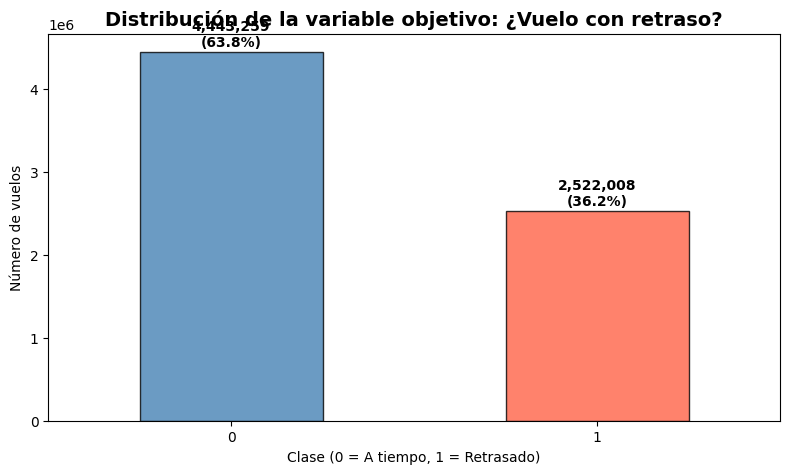


💡 INTERPRETACIÓN Y RECOMENDACIONES:
   ⚠️  Leve desbalance. Recomendado usar AUC, F1-score o recall como métrica principal.

🔧 Sugerencia para XGBoost: usa scale_pos_weight = 1.76


In [7]:
# === ANÁLISIS DEL BALANCE DE CLASES EN LA VARIABLE OBJETIVO ===
print("\n" + "="*60)
print("⚖️  ANÁLISIS DEL BALANCE DE CLASES: VARIABLE 'RETRASO'")
print("="*60)

try:
    # Validar que df_encoded exista y contenga 'retraso'
    if 'df_encoded' not in locals() and 'df_encoded' not in globals():
        raise ValueError("DataFrame 'df_encoded' no encontrado. Ejecuta primero el encoding.")
    if 'retraso' not in df_encoded.columns:
        raise ValueError("Variable objetivo 'retraso' no encontrada en el dataset codificado.")

    y = df_encoded['retraso']

    # Contar valores por clase
    conteo_clases = y.value_counts().sort_index()
    total = len(y)

    print(f"📊 Total de observaciones: {total:,}")
    print("\nDistribución de clases:")
    for clase, conteo in conteo_clases.items():
        porcentaje = (conteo / total) * 100
        print(f"   • Clase {clase} (retraso={'Sí' if clase == 1 else 'No'}): {conteo:,} ({porcentaje:.2f}%)")

    # Calcular métricas de desbalance
    proporcion_mayoritaria = conteo_clases.max() / total
    proporcion_minoritaria = conteo_clases.min() / total
    ratio_desbalance = proporcion_mayoritaria / proporcion_minoritaria

    print(f"\n🔍 Métricas de desbalance:")
    print(f"   • Proporción clase mayoritaria: {proporcion_mayoritaria:.2%}")
    print(f"   • Proporción clase minoritaria: {proporcion_minoritaria:.2%}")
    print(f"   • Ratio de desbalance (mayor/minor): {ratio_desbalance:.1f}:1")

    # === VISUALIZACIÓN ===
    plt.figure(figsize=(8, 5))
    colores = ['steelblue', 'tomato'] if len(conteo_clases) == 2 else 'husl'
    conteo_clases.plot(kind='bar', color=colores, edgecolor='black', alpha=0.8)
    plt.title("Distribución de la variable objetivo: ¿Vuelo con retraso?", fontsize=14, weight='bold')
    plt.xlabel("Clase (0 = A tiempo, 1 = Retrasado)")
    plt.ylabel("Número de vuelos")
    plt.xticks(rotation=0)
    for i, v in enumerate(conteo_clases.values):
        plt.text(i, v + total*0.005, f"{v:,}\n({v/total:.1%})", ha='center', va='bottom', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # === INTERPRETACIÓN Y RECOMENDACIONES ===
    print("\n" + "💡 INTERPRETACIÓN Y RECOMENDACIONES:")
    if ratio_desbalance < 1.5:
        print("   ✅ Clases balanceadas. Puedes usar métricas estándar (accuracy, AUC).")
    elif ratio_desbalance < 5:
        print("   ⚠️  Leve desbalance. Recomendado usar AUC, F1-score o recall como métrica principal.")
    elif ratio_desbalance < 20:
        print("   ⚠️⚠️  Desbalance moderado. Considera técnicas como:")
        print("        • Submuestreo de la clase mayoritaria")
        print("        • Sobremuestreo de la clase minoritaria (SMOTE)")
        print("        • Uso de pesos de clase (class_weight='balanced')")
    else:
        print("   ❗ Desbalance severo. Se requiere tratamiento especial:")
        print("        • SMOTE + submuestreo híbrido")
        print("        • Modelos sensibles al desbalance (XGBoost con scale_pos_weight)")
        print("        • Enfoque en recall o precisión según el caso de uso")

    # Calcular weight para XGBoost (si es binario)
    if len(conteo_clases) == 2:
        neg, pos = conteo_clases[0], conteo_clases[1]
        scale_pos_weight = neg / pos
        print(f"\n🔧 Sugerencia para XGBoost: usa scale_pos_weight = {scale_pos_weight:.2f}")

except Exception as e:
    print(f"❌ Error en el análisis de balance: {str(e)}")

In [8]:
print("\n" + "="*60)
print("⚖️  BALANCEO DE CLASES: TÉCNICAS EFICIENTES EN RAM")
print("="*60)

# Validar que df_encoded y 'retraso' existan
if 'df_encoded' not in locals() or 'retraso' not in df_encoded.columns:
    print("❌ Error: df_encoded o variable 'retraso' no disponibles.")
else:
    X = df_encoded.drop(columns=['retraso'])
    y = df_encoded['retraso'].copy()

    print(f"📊 Dataset original: {X.shape[0]:,} muestras")
    print(f"   • Clase 0 (a tiempo): {(y == 0).sum():,}")
    print(f"   • Clase 1 (retraso): {(y == 1).sum():,}")

    # === OPCIÓN 1: USAR PONDERACIÓN DE CLASES (RECOMENDADO PARA GRANDES DATASETS) ===
    print("\n" + "-"*50)
    print("🔧 OPCIÓN 1: PONDERACIÓN DE CLASES (sin modificar datos)")
    print("-"*50)

    # Calcular class_weight de forma manual (compatible con cualquier modelo)
    neg, pos = (y == 0).sum(), (y == 1).sum()
    class_weight = {0: 1, 1: neg / pos}
    print(f"✅ Peso para clase 0 (a tiempo): {class_weight[0]:.2f}")
    print(f"✅ Peso para clase 1 (retraso): {class_weight[1]:.2f}")
    print("💡 Usar class_weight en modelos (RandomForest, XGBoost, etc.)")

    # Guardar para uso posterior
    balance_config = {
        'estrategia': 'class_weight',
        'class_weight': class_weight,
        'X_train': None,  # Se definirá en train/test split
        'y_train': None
    }

    # === OPCIÓN 2: SUBMUESTREO ALEATORIO (SI RAM ES CRÍTICA) ===
    print("\n" + "-"*50)
    print("🔄 OPCIÓN 2: SUBMUESTREO ALEATORIO (reduce tamaño del dataset)")
    print("-"*50)

    # Calcular el tamaño objetivo: igualar clases (1:1) o mantener 2:1
    ratio_objetivo = 1.0  # 1.0 = balance perfecto, 2.0 = 2x más mayoría
    n_minoritaria = pos
    n_mayoritaria_objetivo = int(n_minoritaria * ratio_objetivo)

    print(f"🎯 Objetivo: {n_mayoritaria_objetivo:,} muestras en clase mayoritaria (ratio {ratio_objetivo}:1)")

    if n_mayoritaria_objetivo >= neg:
        print("ℹ️  No se requiere submuestreo (ratio ya aceptable).")
        X_sub, y_sub = X, y
    else:
        try:
            # Separar índices
            idx_mayoritaria = y[y == 0].index
            idx_minoritaria = y[y == 1].index

            # Submuestrear clase mayoritaria
            idx_mayoritaria_sub = resample(
                idx_mayoritaria,
                replace=False,
                n_samples=n_mayoritaria_objetivo,
                random_state=42
            )

            # Combinar índices
            idx_balanceado = np.concatenate([idx_mayoritaria_sub, idx_minoritaria])
            X_sub = X.loc[idx_balanceado].copy()
            y_sub = y.loc[idx_balanceado].copy()

            print(f"✅ Submuestreo completado: {X_sub.shape[0]:,} muestras totales")
            print(f"   • Clase 0: {sum(y_sub == 0):,}")
            print(f"   • Clase 1: {sum(y_sub == 1):,}")

            # Liberar memoria
            del idx_mayoritaria, idx_minoritaria, idx_mayoritaria_sub, idx_balanceado
            gc.collect()

        except Exception as e:
            print(f"⚠️  Error en submuestreo: {e}")
            X_sub, y_sub = X, y

    # === RESUMEN ===
    print("\n" + "="*60)
    print("📌 RESUMEN DE ESTRATEGIAS")
    print("="*60)
    print("1️⃣  PONDERACIÓN DE CLASES:")
    print("    - No modifica los datos")
    print(f"    - class_weight = {{0: 1, 1: {class_weight[1]:.2f}}}")
    print("    - Ideal para XGBoost, RandomForest, etc.")
    print("\n2️⃣  SUBMUESTREO:")
    print(f"    - Reduce dataset a {X_sub.shape[0]:,} filas")
    print("    - Ahorra RAM, pero pierde información")
    print("\n✅ RECOMENDACIÓN: Usa PONDERACIÓN DE CLASES (más robusto y eficiente)")

    # Guardar datos submuestreados (opcional)
    df_balanceado = pd.concat([X_sub, y_sub], axis=1)

    # Liberar X, y originales si usas submuestreo
    del X, y
    gc.collect()

    print("\n💾 Dataset balanceado (submuestreo) guardado en 'df_balanceado'")
    print(f"📊 Tamaño final: {df_balanceado.shape[0]:,} filas, {df_balanceado.shape[1]} columnas")

    # Nota: para usar SMOTE, se requeriría más RAM → no recomendado en Colab con datasets grandes
    print("\n❗ Nota: SMOTE no se aplica aquí por alto consumo de RAM en datasets grandes.")


⚖️  BALANCEO DE CLASES: TÉCNICAS EFICIENTES EN RAM
📊 Dataset original: 6,965,267 muestras
   • Clase 0 (a tiempo): 4,443,259
   • Clase 1 (retraso): 2,522,008

--------------------------------------------------
🔧 OPCIÓN 1: PONDERACIÓN DE CLASES (sin modificar datos)
--------------------------------------------------
✅ Peso para clase 0 (a tiempo): 1.00
✅ Peso para clase 1 (retraso): 1.76
💡 Usar class_weight en modelos (RandomForest, XGBoost, etc.)

--------------------------------------------------
🔄 OPCIÓN 2: SUBMUESTREO ALEATORIO (reduce tamaño del dataset)
--------------------------------------------------
🎯 Objetivo: 2,522,008 muestras en clase mayoritaria (ratio 1.0:1)
✅ Submuestreo completado: 5,044,016 muestras totales
   • Clase 0: 2,522,008
   • Clase 1: 2,522,008

📌 RESUMEN DE ESTRATEGIAS
1️⃣  PONDERACIÓN DE CLASES:
    - No modifica los datos
    - class_weight = {0: 1, 1: 1.76}
    - Ideal para XGBoost, RandomForest, etc.

2️⃣  SUBMUESTREO:
    - Reduce dataset a 5,044,016


🔗 ANÁLISIS DE CORRELACIÓN ENTRE VARIABLES NUMÉRICAS
📊 Variables numéricas incluidas: 24
   → dep_delay, arr_delay, distance, carrier_delay, weather_delay...


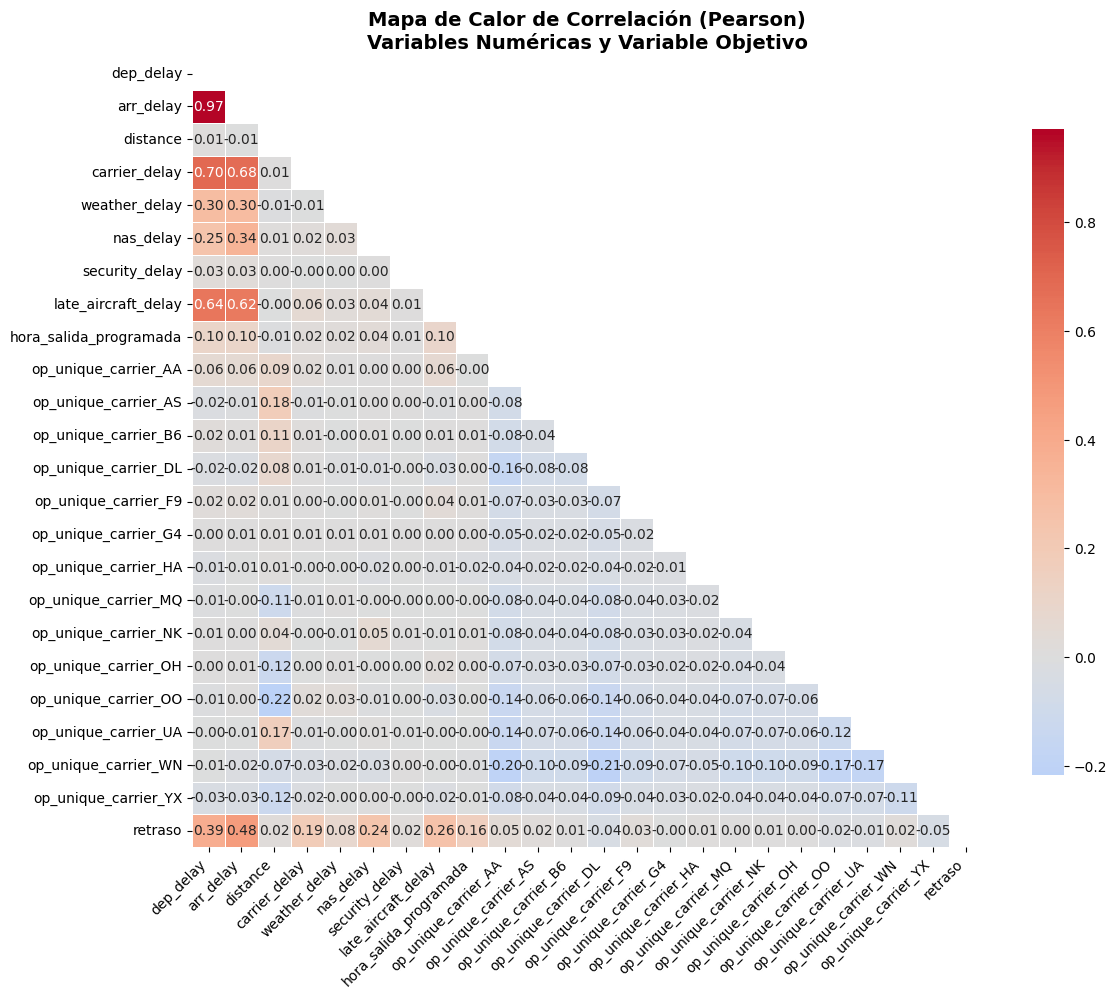


🔍 Correlación con la variable objetivo 'retraso':
   • arr_delay: 0.478 (positiva)
   • dep_delay: 0.385 (positiva)
   • late_aircraft_delay: 0.256 (positiva)
   • nas_delay: 0.240 (positiva)
   • carrier_delay: 0.190 (positiva)
   • hora_salida_programada: 0.158 (positiva)

💡 INSIGHTS:
• Correlaciones > |0.7| indican multicolinealidad (pueden afectar modelos lineales).
• Variables con alta correlación con 'retraso' son buenas candidatas para el modelo.
• Los retrasos suelen estar fuertemente correlacionados con 'dep_delay', 'carrier_delay', etc.


In [9]:


print("\n" + "="*60)
print("🔗 ANÁLISIS DE CORRELACIÓN ENTRE VARIABLES NUMÉRICAS")
print("="*60)

try:
    # Validar que df_encoded exista
    if 'df_encoded' not in locals() and 'df_encoded' not in globals():
        raise ValueError("DataFrame 'df_encoded' no encontrado. Ejecuta primero el encoding.")

    # Seleccionar solo columnas numéricas (excluir 'retraso' por ahora, se añadirá después)
    numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()

    if 'retraso' in numeric_cols:
        # Mover 'retraso' al final para que aparezca en el heatmap
        numeric_cols = [col for col in numeric_cols if col != 'retraso'] + ['retraso']

    if len(numeric_cols) < 2:
        raise ValueError("No hay suficientes variables numéricas para calcular correlación.")

    print(f"📊 Variables numéricas incluidas: {len(numeric_cols)}")
    print(f"   → {', '.join(numeric_cols[:5])}" + ("..." if len(numeric_cols) > 5 else ""))

    # Calcular matriz de correlación (Pearson)
    corr_matrix = df_encoded[numeric_cols].corr()

    # === VISUALIZACIÓN: MAPA DE CALOR ===
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mostrar solo triángulo inferior
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )
    plt.title("Mapa de Calor de Correlación (Pearson)\nVariables Numéricas y Variable Objetivo", fontsize=14, weight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # === ANÁLISIS: CORRELACIÓN CON LA VARIABLE OBJETIVO ===
    print("\n🔍 Correlación con la variable objetivo 'retraso':")
    if 'retraso' in corr_matrix.columns:
        corr_con_retraso = corr_matrix['retraso'].drop('retraso').sort_values(key=abs, ascending=False)
        for var, valor in corr_con_retraso.items():
            if abs(valor) > 0.1:  # Solo mostrar correlaciones relevantes
                direccion = "positiva" if valor > 0 else "negativa"
                print(f"   • {var}: {valor:.3f} ({direccion})")
        if all(abs(corr_con_retraso) <= 0.1):
            print("   Ninguna variable muestra correlación fuerte (>|0.1|) con 'retraso'.")
    else:
        print("⚠️  'retraso' no está en la matriz de correlación.")

    # === INSIGHTS CLAVE ===
    print("\n💡 INSIGHTS:")
    print("• Correlaciones > |0.7| indican multicolinealidad (pueden afectar modelos lineales).")
    print("• Variables con alta correlación con 'retraso' son buenas candidatas para el modelo.")
    print("• Los retrasos suelen estar fuertemente correlacionados con 'dep_delay', 'carrier_delay', etc.")

except Exception as e:
    print(f"❌ Error en el análisis de correlación: {str(e)}")


🎯 ANÁLISIS DE CORRELACIÓN CON LA VARIABLE OBJETIVO 'RETRASO'
📊 Analizando correlación de 23 variables numéricas con 'retraso'...


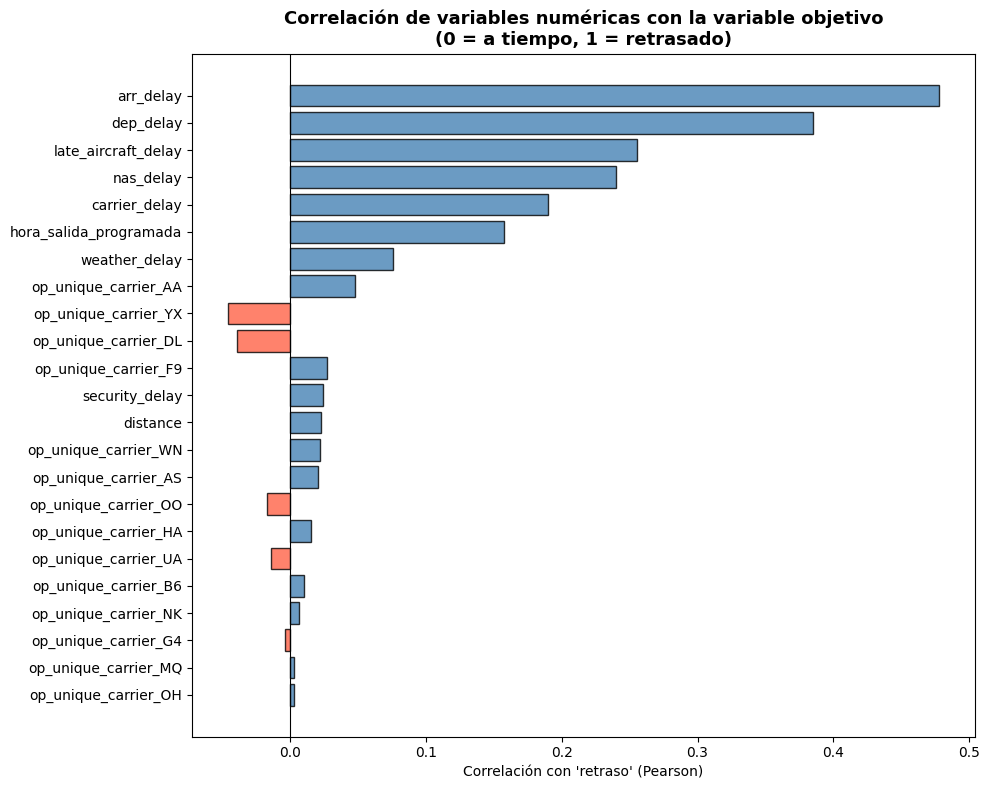


🔍 Clasificación por fuerza de correlación con 'retraso':

💪 Correlaciones FUERTES (|r| ≥ 0.3):
   • arr_delay: 0.478 (positiva ↑)
   • dep_delay: 0.385 (positiva ↑)

📊 Correlaciones MODERADAS (0.1 ≤ |r| < 0.3):
   • late_aircraft_delay: 0.256 (positiva ↑)
   • nas_delay: 0.240 (positiva ↑)
   • carrier_delay: 0.190 (positiva ↑)
   • hora_salida_programada: 0.158 (positiva ↑)

📏 Correlaciones débiles (|r| < 0.1): 17 variables (no mostradas)

🏆 Top 5 predictores más correlacionados con 'retraso':
   1. arr_delay = 0.478 ↑
   2. dep_delay = 0.385 ↑
   3. late_aircraft_delay = 0.256 ↑
   4. nas_delay = 0.240 ↑
   5. carrier_delay = 0.190 ↑

💡 INTERPRETACIÓN:
• Correlación positiva ↑: mayor valor → más probabilidad de retraso.
• Correlación negativa ↓: mayor valor → menos probabilidad de retraso.
• En datos de vuelos, 'dep_delay' y 'carrier_delay' suelen ser los predictores más fuertes.


In [10]:
# === ANÁLISIS DE CORRELACIÓN CON LA VARIABLE OBJETIVO ===


print("\n" + "="*60)
print("🎯 ANÁLISIS DE CORRELACIÓN CON LA VARIABLE OBJETIVO 'RETRASO'")
print("="*60)

try:
    # Validar disponibilidad del dataset
    if 'df_encoded' not in locals() and 'df_encoded' not in globals():
        raise ValueError("DataFrame 'df_encoded' no encontrado. Ejecuta primero el encoding.")
    if 'retraso' not in df_encoded.columns:
        raise ValueError("Variable objetivo 'retraso' no encontrada.")

    # Seleccionar solo variables numéricas (excluir la propia 'retraso' del listado de predictores)
    numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
    predictor_cols = [col for col in numeric_cols if col != 'retraso']

    if not predictor_cols:
        raise ValueError("No se encontraron variables numéricas además de 'retraso'.")

    print(f"📊 Analizando correlación de {len(predictor_cols)} variables numéricas con 'retraso'...")

    # Calcular correlación (Pearson) con la variable objetivo
    corr_with_target = df_encoded[predictor_cols].corrwith(df_encoded['retraso']).sort_values(key=abs, ascending=False)

    # Convertir a DataFrame para facilitar visualización
    corr_df = pd.DataFrame({
        'variable': corr_with_target.index,
        'correlacion': corr_with_target.values,
        'abs_correlacion': corr_with_target.abs().values
    })

    # === VISUALIZACIÓN: BARRAS DE CORRELACIÓN ===
    plt.figure(figsize=(10, 8))
    colors = ['tomato' if x < 0 else 'steelblue' for x in corr_df['correlacion']]
    plt.barh(corr_df['variable'], corr_df['correlacion'], color=colors, edgecolor='black', alpha=0.8)
    plt.xlabel("Correlación con 'retraso' (Pearson)")
    plt.title("Correlación de variables numéricas con la variable objetivo\n(0 = a tiempo, 1 = retrasado)", fontsize=13, weight='bold')
    plt.axvline(0, color='black', linewidth=0.8)
    plt.gca().invert_yaxis()  # Más importante arriba
    plt.tight_layout()
    plt.show()

    # === CLASIFICACIÓN POR FUERZA DE CORRELACIÓN ===
    print("\n🔍 Clasificación por fuerza de correlación con 'retraso':")

    fuertes = corr_df[corr_df['abs_correlacion'] >= 0.3]
    moderadas = corr_df[(corr_df['abs_correlacion'] >= 0.1) & (corr_df['abs_correlacion'] < 0.3)]
    debiles = corr_df[corr_df['abs_correlacion'] < 0.1]

    if not fuertes.empty:
        print(f"\n💪 Correlaciones FUERTES (|r| ≥ 0.3):")
        for _, row in fuertes.iterrows():
            dir_txt = "positiva ↑" if row['correlacion'] > 0 else "negativa ↓"
            print(f"   • {row['variable']}: {row['correlacion']:.3f} ({dir_txt})")
    else:
        print("\n💪 No hay correlaciones fuertes (|r| ≥ 0.3).")

    if not moderadas.empty:
        print(f"\n📊 Correlaciones MODERADAS (0.1 ≤ |r| < 0.3):")
        for _, row in moderadas.iterrows():
            dir_txt = "positiva ↑" if row['correlacion'] > 0 else "negativa ↓"
            print(f"   • {row['variable']}: {row['correlacion']:.3f} ({dir_txt})")

    print(f"\n📏 Correlaciones débiles (|r| < 0.1): {len(debiles)} variables (no mostradas)")

    # === TOP 5 VARIABLES MÁS CORRELACIONADAS ===
    top5 = corr_df.head(5)
    print(f"\n🏆 Top 5 predictores más correlacionados con 'retraso':")
    for i, (_, row) in enumerate(top5.iterrows(), 1):
        dir_emoji = "↑" if row['correlacion'] > 0 else "↓"
        print(f"   {i}. {row['variable']} = {row['correlacion']:.3f} {dir_emoji}")

    # === INTERPRETACIÓN ===
    print("\n" + "💡 INTERPRETACIÓN:")
    print("• Correlación positiva ↑: mayor valor → más probabilidad de retraso.")
    print("• Correlación negativa ↓: mayor valor → menos probabilidad de retraso.")
    print("• En datos de vuelos, 'dep_delay' y 'carrier_delay' suelen ser los predictores más fuertes.")

except Exception as e:
    print(f"❌ Error en el análisis de correlación con la variable objetivo: {str(e)}")

In [11]:
# SEPARACIÓN DE DATOS
# Dividir el conjunto de datos en entrenamiento y prueba



print("\n" + "="*60)
print("✂️  SEPARACIÓN DE DATOS: TRAIN Y TEST")
print("="*60)

try:
    # Buscar el DataFrame más adecuado disponible
    df_usar = None
    if 'df_encoded' in locals() or 'df_encoded' in globals():
        df_usar = df_encoded
        print("✅ Usando 'df_encoded' para la división.")
    elif 'df' in locals() or 'df' in globals():
        df_usar = df
        print("⚠️  'df_encoded' no encontrado. Usando 'df' como fuente.")
    else:
        raise ValueError("Ni 'df_encoded' ni 'df' están disponibles. Ejecuta la carga y preparación.")

    # Asegurar que exista la variable objetivo 'retraso'
    if 'retraso' not in df_usar.columns:
        if 'arr_delay' in df_usar.columns:
            print("🔄 Variable 'retraso' no encontrada. Creando desde 'arr_delay'...")
            df_usar = df_usar.copy()
            df_usar['retraso'] = (df_usar['arr_delay'] > 0).astype(int)
        else:
            raise ValueError("Variable objetivo 'retraso' no encontrada y no se puede derivar.")

    # Preparar X e y
    X = df_usar.drop(columns=['retraso'])
    y = df_usar['retraso']

    print(f"📊 Dataset completo: {X.shape[0]:,} muestras, {X.shape[1]} características")
    print(f"🎯 Proporción de retrasos: {y.mean():.2%}")

    # Dividir con estratificación
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42,
        shuffle=True
    )

    print(f"\n✅ División completada:")
    print(f"   • Train: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X):.1%})")
    print(f"     - Retrasos en train: {y_train.mean():.2%}")
    print(f"   • Test:  {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X):.1%})")
    print(f"     - Retrasos en test:  {y_test.mean():.2%}")

    # Verificar proporciones
    diff_prop = abs(y_train.mean() - y_test.mean())
    if diff_prop < 0.001:
        print("✅ Proporción de clases preservada correctamente en train/test.")
    else:
        print(f"⚠️  Pequeña diferencia en proporciones: {diff_prop:.4f}")

    # Liberar el DataFrame original para ahorrar RAM
    if 'df_encoded' in locals() or 'df_encoded' in globals():
        del df_encoded
    if 'df' in locals() or 'df' in globals():
        del df
    gc.collect()
    print("\n🧹 DataFrames originales eliminados. Solo se mantienen X_train, X_test, y_train, y_test.")

except Exception as e:
    print(f"❌ Error al dividir los datos: {str(e)}")
    X_train = X_test = y_train = y_test = None


✂️  SEPARACIÓN DE DATOS: TRAIN Y TEST
✅ Usando 'df_encoded' para la división.
📊 Dataset completo: 6,965,267 muestras, 27 características
🎯 Proporción de retrasos: 36.21%

✅ División completada:
   • Train: 5,572,213 muestras (80.0%)
     - Retrasos en train: 36.21%
   • Test:  1,393,054 muestras (20.0%)
     - Retrasos en test:  36.21%
✅ Proporción de clases preservada correctamente en train/test.

🧹 DataFrames originales eliminados. Solo se mantienen X_train, X_test, y_train, y_test.


In [12]:
# CREACIÓN DE MODELOS PREDICTIVOS (SIN DATA LEAKAGE)
# Solo usa variables disponibles ANTES de la salida del vuelo

print("\n" + "="*60)
print("🤖 CREACIÓN DE MODELOS (FEATURES SIN LEAKAGE)")
print("="*60)

# === 1. VERIFICAR DATOS ===
if not all(var in globals() for var in ['X_train', 'X_test', 'y_train', 'y_test']):
    print("❌ Error: Conjuntos de train/test no encontrados.")
    print("⚠️  Ejecuta primero el bloque de separación de datos.")
    modelos = {}
else:
    print("✅ Conjuntos de train/test disponibles.")

    # === 2. DEFINIR FEATURES SEGURAS (sin leakage) ===
    features_seguras = [
        'op_unique_carrier',
        'origin',
        'dest',
        'origin_state_nm',
        'dest_state_nm',
        'distance',
        'dia_semana',
        'mes',
        'crs_dep_time',
        'crs_arrival_time',
        'hora_salida_programada',
    ]

    # Filtrar solo las features seguras que existan
    features_existentes = [col for col in features_seguras if col in X_train.columns]
    print(f"✅ Usando {len(features_existentes)} features seguras (sin leakage):")
    print(f"   → {', '.join(features_existentes)}")

    X_train_seguro = X_train[features_existentes].copy()
    X_test_seguro = X_test[features_existentes].copy()
    y_train_seguro = y_train.copy()
    y_test_seguro = y_test.copy()

    # === 3. PREPROCESAR CATEGÓRICAS (Label Encoding) ===
    print("\n🧹 Codificando variables categóricas...")
    cat_cols = X_train_seguro.select_dtypes(include=['object', 'category']).columns.tolist()

    if cat_cols:
        for col in cat_cols:
            # Asegurar que train y test usen el mismo encoder
            all_vals = pd.concat([X_train_seguro[col], X_test_seguro[col]]).astype(str).unique()
            le = LabelEncoder().fit(all_vals)
            X_train_seguro[col] = le.transform(X_train_seguro[col].astype(str))
            X_test_seguro[col] = le.transform(X_test_seguro[col].astype(str))
        print("✅ Codificación completada.")

    # Convertir a numérico (por si hay strings residuales)
    X_train_seguro = X_train_seguro.apply(pd.to_numeric, errors='coerce').fillna(-1)
    X_test_seguro = X_test_seguro.apply(pd.to_numeric, errors='coerce').fillna(-1)

    # === 4. ENTRENAR MODELOS ===
    modelos = {}
    metricas = {}

    # --- XGBoost (recomendado) ---
    print("\n" + "-"*50)
    print("⚡ Entrenando XGBoost (features sin leakage)...")
    try:
        neg, pos = (y_train_seguro == 0).sum(), (y_train_seguro == 1).sum()
        scale_pos_weight = neg / pos

        xgb_model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        xgb_model.fit(X_train_seguro, y_train_seguro)
        y_pred_xgb = xgb_model.predict(X_test_seguro)
        y_proba_xgb = xgb_model.predict_proba(X_test_seguro)[:, 1]

        metricas['XGBoost'] = {
            'AUC': roc_auc_score(y_test_seguro, y_proba_xgb),
            'F1': f1_score(y_test_seguro, y_pred_xgb),
            'Recall': recall_score(y_test_seguro, y_pred_xgb)
        }
        modelos['XGBoost'] = (xgb_model, y_pred_xgb, y_proba_xgb)
        print(f"✅ AUC: {metricas['XGBoost']['AUC']:.4f} | F1: {metricas['XGBoost']['F1']:.4f}")
        print(f"   🔧 scale_pos_weight = {scale_pos_weight:.2f}")

    except Exception as e:
        print(f"❌ Error en XGBoost: {e}")

    # --- Random Forest (ligero) ---
    print("\n" + "-"*50)
    print("🌳 Entrenando Random Forest (rápido)...")
    try:
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=8,
            min_samples_split=500,
            min_samples_leaf=250,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train_seguro, y_train_seguro)
        y_pred_rf = rf.predict(X_test_seguro)
        y_proba_rf = rf.predict_proba(X_test_seguro)[:, 1]

        metricas['Random Forest'] = {
            'AUC': roc_auc_score(y_test_seguro, y_proba_rf),
            'F1': f1_score(y_test_seguro, y_pred_rf),
            'Recall': recall_score(y_test_seguro, y_pred_rf)
        }
        modelos['Random Forest'] = (rf, y_pred_rf, y_proba_rf)
        print(f"✅ AUC: {metricas['Random Forest']['AUC']:.4f} | F1: {metricas['Random Forest']['F1']:.4f}")

    except Exception as e:
        print(f"❌ Error en Random Forest: {e}")

    # === 5. GUARDAR RESULTADOS PARA EVALUACIÓN ===
    if modelos:
        globals()['y_test_eval'] = y_test_seguro
        for nombre, (modelo, y_pred, y_proba) in modelos.items():
            globals()[f'modelo_{nombre.lower().replace(" ", "_")}'] = modelo
            globals()[f'y_pred_{nombre.lower().replace(" ", "_")}'] = y_pred
            globals()[f'y_proba_{nombre.lower().replace(" ", "_")}'] = y_proba
        print("\n✅ Modelos entrenados y listos para evaluación.")
    else:
        print("❌ No se entrenó ningún modelo.")

    # Liberar memoria
    del X_train_seguro, X_test_seguro, y_train_seguro, y_test_seguro
    gc.collect()


🤖 CREACIÓN DE MODELOS (FEATURES SIN LEAKAGE)
✅ Conjuntos de train/test disponibles.
✅ Usando 6 features seguras (sin leakage):
   → origin, dest, origin_state_nm, dest_state_nm, distance, hora_salida_programada

🧹 Codificando variables categóricas...
✅ Codificación completada.

--------------------------------------------------
⚡ Entrenando XGBoost (features sin leakage)...
✅ AUC: 0.6356 | F1: 0.5230
   🔧 scale_pos_weight = 1.76

--------------------------------------------------
🌳 Entrenando Random Forest (rápido)...
✅ AUC: 0.6209 | F1: 0.5169

✅ Modelos entrenados y listos para evaluación.



🔍 EVALUACIÓN DE MODELOS: ENFOQUE EN DESEQUILIBRIO
✅ Evaluando 2 modelo(s): ['XGBoost', 'Random Forest']

📊 XGBoost:
   • AUC-ROC: 0.6356 | AUC-PR: 0.4815
   • F1: 0.5230 | Recall: 0.6173 | Precision: 0.4537

📊 Random Forest:
   • AUC-ROC: 0.6209 | AUC-PR: 0.4633
   • F1: 0.5169 | Recall: 0.6264 | Precision: 0.4400

📈 TABLA COMPARATIVA DE MÉTRICAS
       Modelo  AUC-ROC  AUC-PR  F1-Score  Recall  Precision  Accuracy
      XGBoost   0.6356  0.4815    0.5230  0.6173     0.4537    0.5923
Random Forest   0.6209  0.4633    0.5169  0.6264     0.4400    0.5760


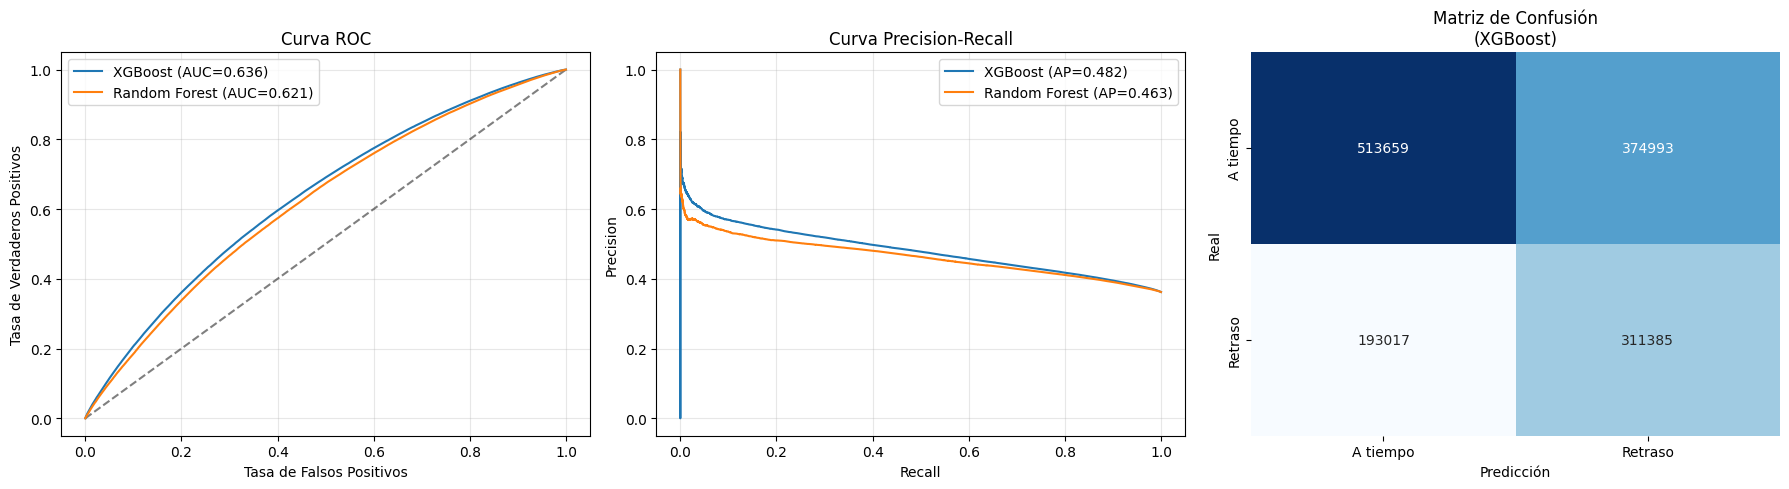


📋 REPORTE DE CLASIFICACIÓN: XGBoost
              precision    recall  f1-score   support

    A tiempo       0.73      0.58      0.64    888652
     Retraso       0.45      0.62      0.52    504402

    accuracy                           0.59   1393054
   macro avg       0.59      0.60      0.58   1393054
weighted avg       0.63      0.59      0.60   1393054


💡 INTERPRETACIÓN PARA OPERACIONES AÉREAS:
• El modelo identifica correctamente el 61.7% de los vuelos que se retrasan (Recall).
• El 45.4% de los vuelos predichos como 'retrasados' realmente lo están (Precision).


In [13]:
# EVALUACIÓN DE LOS MODELOS (CORREGIDO PARA EVITAR ERRORES DE FORMATO)


print("\n" + "="*60)
print("🔍 EVALUACIÓN DE MODELOS: ENFOQUE EN DESEQUILIBRIO")
print("="*60)

try:
    if 'y_test' not in globals():
        raise ValueError("❌ y_test no encontrado. Ejecuta primero el modelado.")

    # Detectar modelos disponibles
    modelos_disponibles = {}
    if 'y_pred_xgb' in globals() and 'y_proba_xgb' in globals():
        modelos_disponibles['XGBoost'] = (globals()['y_pred_xgb'], globals()['y_proba_xgb'])
    if 'y_pred_rf' in globals() and 'y_proba_rf' in globals():
        modelos_disponibles['Random Forest'] = (globals()['y_pred_rf'], globals()['y_proba_rf'])

    if not modelos_disponibles:
        raise ValueError("❌ No se encontraron predicciones de modelos.")

    print(f"✅ Evaluando {len(modelos_disponibles)} modelo(s): {list(modelos_disponibles.keys())}")

    resultados = []

    for nombre, (y_pred, y_proba) in modelos_disponibles.items():
        # Asegurar que las métricas sean escalares (promedio binario)
        auc_val = float(roc_auc_score(y_test, y_proba))
        ap_val = float(average_precision_score(y_test, y_proba))
        f1_val = float(f1_score(y_test, y_pred, average='binary'))
        recall_val = float(recall_score(y_test, y_pred, average='binary'))
        precision_val = float(precision_score(y_test, y_pred, average='binary'))
        accuracy_val = float((y_pred == y_test).mean())

        resultados.append({
            'Modelo': nombre,
            'AUC-ROC': auc_val,
            'AUC-PR': ap_val,
            'F1-Score': f1_val,
            'Recall': recall_val,
            'Precision': precision_val,
            'Accuracy': accuracy_val
        })

        print(f"\n📊 {nombre}:")
        print(f"   • AUC-ROC: {auc_val:.4f} | AUC-PR: {ap_val:.4f}")
        print(f"   • F1: {f1_val:.4f} | Recall: {recall_val:.4f} | Precision: {precision_val:.4f}")

    df_metricas = pd.DataFrame(resultados).round(4)
    df_metricas = df_metricas.sort_values('AUC-PR', ascending=False)
    print("\n" + "="*70)
    print("📈 TABLA COMPARATIVA DE MÉTRICAS")
    print("="*70)
    print(df_metricas.to_string(index=False))

    # === VISUALIZACIONES ===
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Curva ROC
    axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    for nombre, (_, y_proba) in modelos_disponibles.items():
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_val = roc_auc_score(y_test, y_proba)
        axes[0].plot(fpr, tpr, label=f"{nombre} (AUC={auc_val:.3f})")
    axes[0].set_xlabel("Tasa de Falsos Positivos")
    axes[0].set_ylabel("Tasa de Verdaderos Positivos")
    axes[0].set_title("Curva ROC")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Curva Precision-Recall
    for nombre, (_, y_proba) in modelos_disponibles.items():
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
        ap_val = average_precision_score(y_test, y_proba)
        axes[1].plot(recall_vals, precision_vals, label=f"{nombre} (AP={ap_val:.3f})")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("Curva Precision-Recall")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Matriz de confusión del mejor modelo
    mejor_modelo = df_metricas.iloc[0]['Modelo']
    y_pred_mejor = modelos_disponibles[mejor_modelo][0]
    cm = confusion_matrix(y_test, y_pred_mejor)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['A tiempo', 'Retraso'],
                yticklabels=['A tiempo', 'Retraso'], ax=axes[2])
    axes[2].set_title(f"Matriz de Confusión\n({mejor_modelo})")
    axes[2].set_ylabel("Real")
    axes[2].set_xlabel("Predicción")

    plt.tight_layout()
    plt.show()

    # === REPORTE DEL MEJOR MODELO ===
    print("\n" + "="*60)
    print(f"📋 REPORTE DE CLASIFICACIÓN: {mejor_modelo}")
    print("="*60)
    print(classification_report(y_test, y_pred_mejor, target_names=['A tiempo', 'Retraso']))

    # === INSIGHTS (usando valores escalares explícitos) ===
    recall_mejor = df_metricas.iloc[0]['Recall']
    precision_mejor = df_metricas.iloc[0]['Precision']
    print("\n" + "💡 INTERPRETACIÓN PARA OPERACIONES AÉREAS:")
    print(f"• El modelo identifica correctamente el {recall_mejor:.1%} de los vuelos que se retrasan (Recall).")
    print(f"• El {precision_mejor:.1%} de los vuelos predichos como 'retrasados' realmente lo están (Precision).")

except Exception as e:
    print(f"❌ Error en la evaluación: {str(e)}")
    import traceback
    traceback.print_exc()  # Opcional: muestra detalles del error